In [16]:
import os 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import sim functions
from neurodsp.sim import (sim_oscillation, sim_bursty_oscillation, sim_variable_oscillation, sim_damped_oscillation)
from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

# 시드 설정 - 동일한 시뮬레이션 결과를 위해 설정
# 1000_data: seed = 10
# 2000_data: seed = 20
# 10000_data: seed = 100 
np.random.seed(20)

# Set some general settings, to be used across all simulations
num_signals = 2000
fs = 2000 #sampling 주파수
n_seconds = 2 #simulation 지속시간
times = create_times(n_seconds, fs) #시간 백터

fpath = "../../data/synthetic_data/evaluation_data/"
Clean = np.load(fpath + 'clean_data.npy')
Clean = Clean[0:num_signals, :]

In [17]:
# Generate artifact
frequency = 125
period = 1 / frequency
num_waveforms = int(np.ceil(times[-1] / period))
samples_per_period = int(fs * period) +1

sine_artifact = np.zeros((0, len(times)))  # (0, 4000)
asymmetric_artifact = np.zeros((0, len(times)))  # (0, 4000)
randamplitude_artifact = np.zeros((0, len(times)))  # (0, 4000)
random_amplitudes = np.zeros((0, len(times)))  # (0, 4000)

Artifact = np.zeros((0, len(times)))  # (0, 4000)

print(num_waveforms)
print(samples_per_period)

250
17


In [18]:
# ------------------------------------<< non-sinusoidal oscillation >>------------------------------------------------------------------------------------------
# Define settings
rdsym = 0.2

# Simulate a non-sinusoidal oscillation
for idx in range(num_signals):
    # Generate a 130 Hz sine wave
    osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

    asymmetric_artifact = np.append(asymmetric_artifact, [osc_shape], axis=0)

print("Clean shape:", Clean.shape)  # (100, 4000)

# 음의 값이 2배가 되도록 y축 shifting
asymmetric_artifact = asymmetric_artifact * 1.75 - 0.75

# randamplitude 추가
random_amplitudes = np.random.uniform(0.95, 1.05, (num_signals, num_waveforms))

# Initialize randamplitude_artifact for the number of signals
randamplitude_artifact = np.zeros((num_signals, len(times)))

for signal_idx in range(num_signals):
    for waveform_idx in range(num_waveforms):
        start_idx = waveform_idx * samples_per_period
        end_idx = min((waveform_idx + 1) * samples_per_period, len(times))

        if start_idx >= len(times):
            break

        each_period = np.zeros(len(times))
        each_period[start_idx:end_idx] = asymmetric_artifact[signal_idx, start_idx:end_idx] * random_amplitudes[signal_idx, waveform_idx]
        randamplitude_artifact[signal_idx, start_idx:end_idx] += each_period[start_idx:end_idx]

# Apply artifacts and store in Artifact array
for i in range(num_signals):
    x = np.min(Clean[i, :]) * 10 / np.min(randamplitude_artifact[i, :])
    Contaminated_signal = Clean[i, :] + randamplitude_artifact[i, :] * x

    Artifact = np.append(Artifact, [Contaminated_signal], axis=0)

print("Artifact shape:", Artifact.shape)  # (100, 4000)

Clean shape: (2000, 4000)
Artifact shape: (2000, 4000)


data_signal shape: (2000, 4000)
signal_with_artifact shape: (2000, 4000)


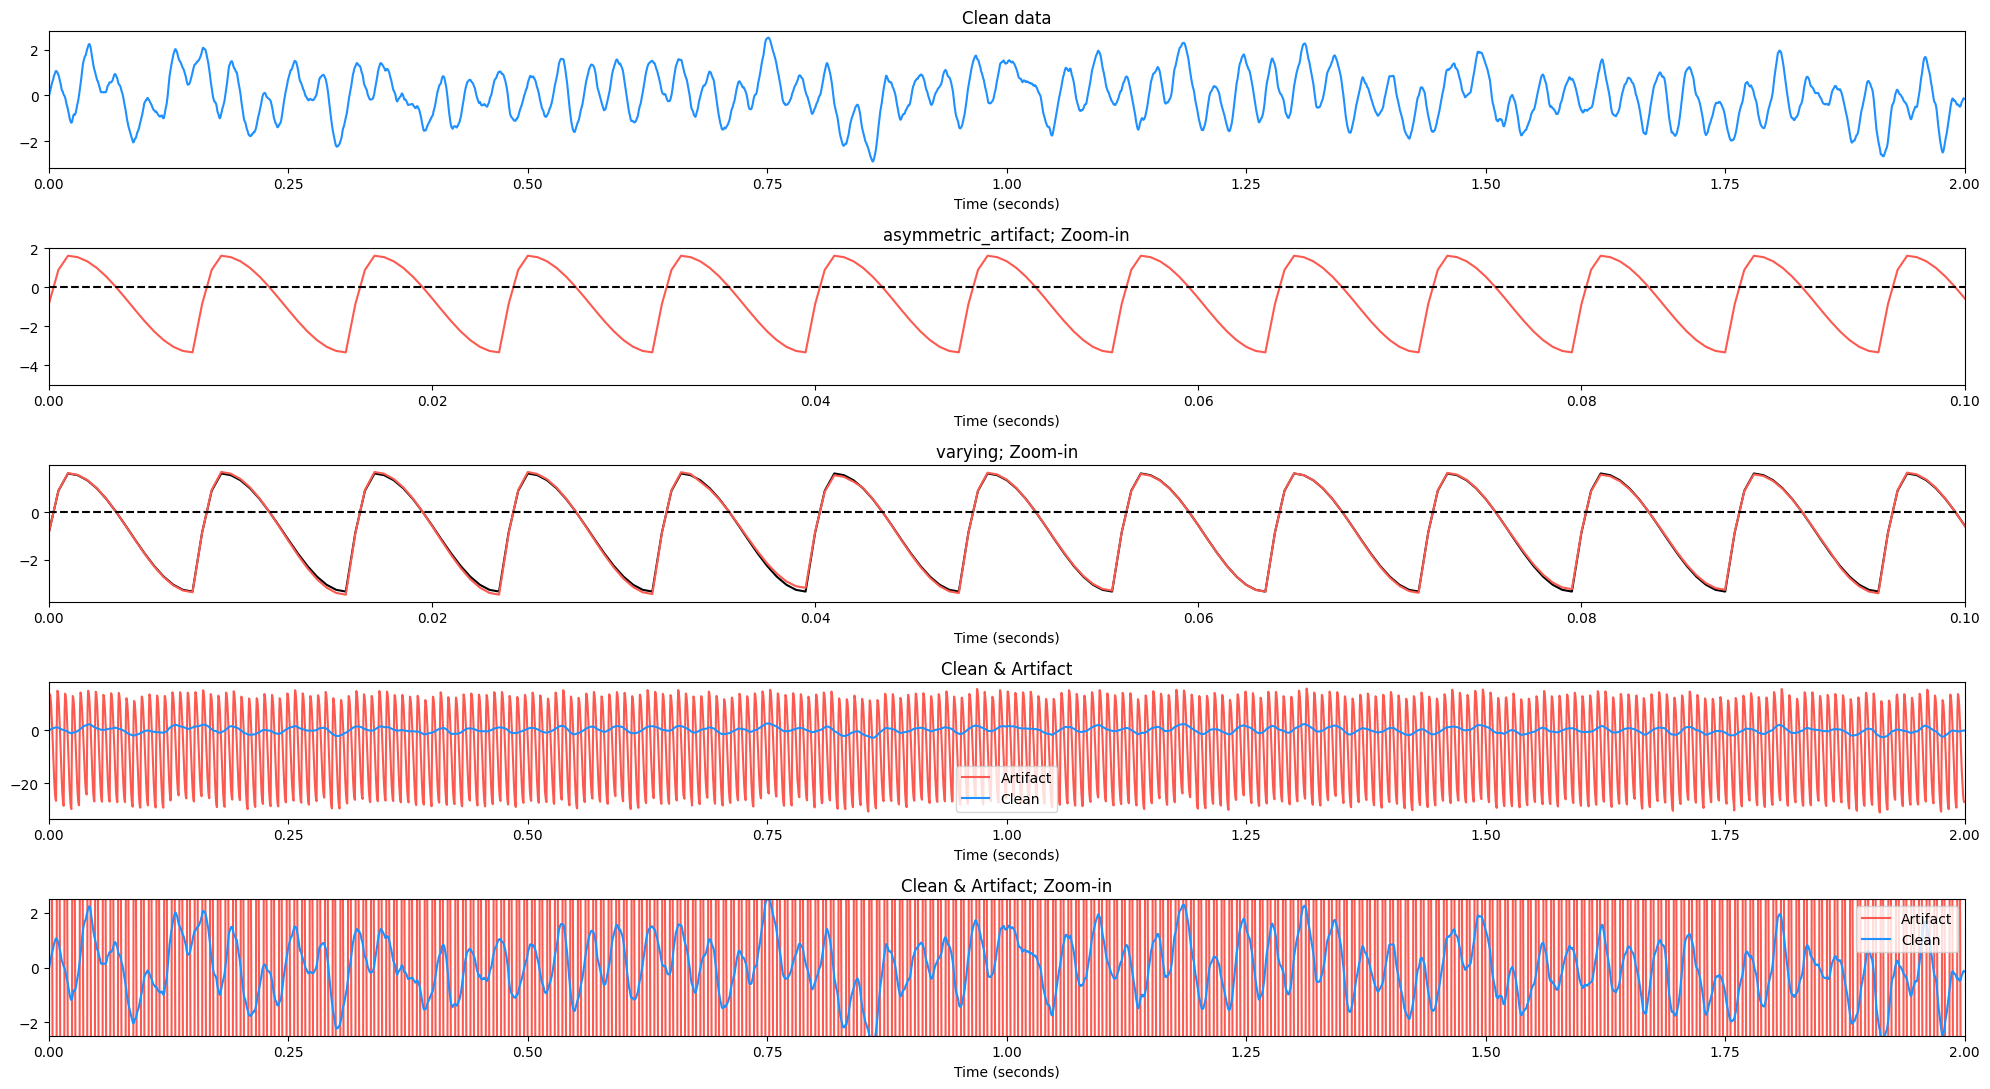

In [19]:
plt.figure(figsize=(20, 11))

num_sample = 0

plt.subplot(5, 1, 1)
plt.plot(times, Clean[num_sample, :], c='dodgerblue')
plt.xlim([0, 2])
plt.xlabel("Time (seconds)"); plt.title('Clean data')

plt.subplot(5, 1, 2)
plt.plot(times, asymmetric_artifact[num_sample, :], c='xkcd:coral'); plt.gca().set_ylim([-5, 2])
plt.axhline(y=0, color='k', linestyle='--')
plt.xlim([0, 0.1])
plt.xlabel("Time (seconds)"); plt.title('asymmetric_artifact; Zoom-in')

plt.subplot(5, 1, 3)
plt.plot(times, asymmetric_artifact[num_sample, :], c='k')
plt.plot(times, randamplitude_artifact[num_sample, :], c='xkcd:coral'); plt.gca()
plt.axhline(y=0, color='k', linestyle='--')
plt.xlim([0, 0.1])
plt.xlabel("Time (seconds)"); plt.title('varying; Zoom-in')

plt.subplot(5, 1, 4)
plt.plot(times, Artifact[num_sample, :], c='xkcd:coral', label = 'Artifact')
plt.plot(times, Clean[num_sample, :], c='dodgerblue', label = 'Clean')
plt.legend()
plt.xlabel("Time (seconds)"); plt.title('Clean & Artifact')
plt.xlim([0, 2])

plt.subplot(5, 1, 5)
plt.plot(times, Artifact[num_sample, :], c='xkcd:coral', label = 'Artifact')
plt.plot(times, Clean[num_sample, :], c='dodgerblue', label = 'Clean')
plt.legend()
plt.xlabel("Time (seconds)"); plt.title('Clean & Artifact; Zoom-in')
plt.xlim([0, 2])
plt.ylim([-2.5, 2.5])

plt.tight_layout()

print('data_signal shape:', Clean.shape)
print('signal_with_artifact shape:', Artifact.shape)

In [20]:
# -------- < 저장 > ------------------------------------------------
# -------- < data > ------------------------------------------------

np.save(fpath + "realistic_artifact_data" + ".npy", Artifact)
